In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_color_codes("pastel")

In [3]:
partial_df = pd.read_csv("data/processed/full_dataset.csv",
                         usecols=['order_id', 'product_id', 'order_dow',
                                  'order_hour_of_day', 'days_since_prior_order'],
                         dtype={
                             'order_id': np.int32,
                             'product_id': np.uint16,
                             'order_number': np.int16,
                             'order_dow': np.int8,
                             'order_hour_of_day': np.int8,
                             'days_since_prior_order': np.float32})

In [4]:
partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 5 columns):
order_id                  int32
product_id                uint16
order_dow                 int8
order_hour_of_day         int8
days_since_prior_order    float32
dtypes: float32(1), int32(1), int8(2), uint16(1)
memory usage: 371.2 MB


## Order by day of the week X hour of the day

In [5]:
order_by_hour = partial_df[['order_dow', 'order_hour_of_day', 'order_id']].groupby(['order_dow', 'order_hour_of_day']).count()
order_by_hour.columns = ['count']
order_by_hour = order_by_hour.reset_index()

In [6]:
order_by_hour = order_by_hour.pivot("order_dow", "order_hour_of_day", "count")

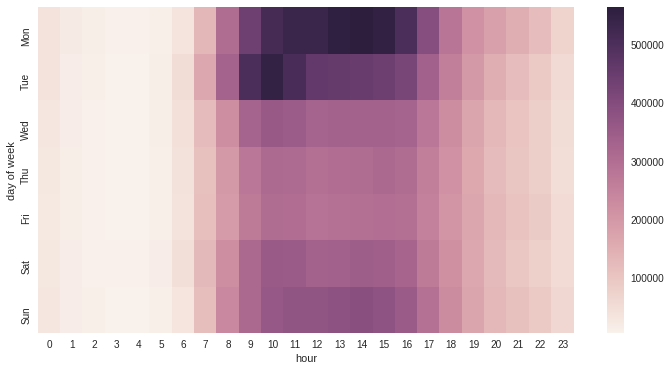

In [7]:
f, ax = plt.subplots(figsize=(12, 6))

ax = sns.heatmap(order_by_hour)
ax.set_xlabel('hour')
ax.set_ylabel('day of week')
ax.set_yticklabels('Mon Tue Wed Thu Fri Sat Sun'.split()[::-1])

plt.show()

## Number of orders after N days since prior order

In [8]:
summary_days_since_prior_order = partial_df['days_since_prior_order'].value_counts()

In [9]:
summary_days_since_prior_order.index = summary_days_since_prior_order.index.astype(np.int16)

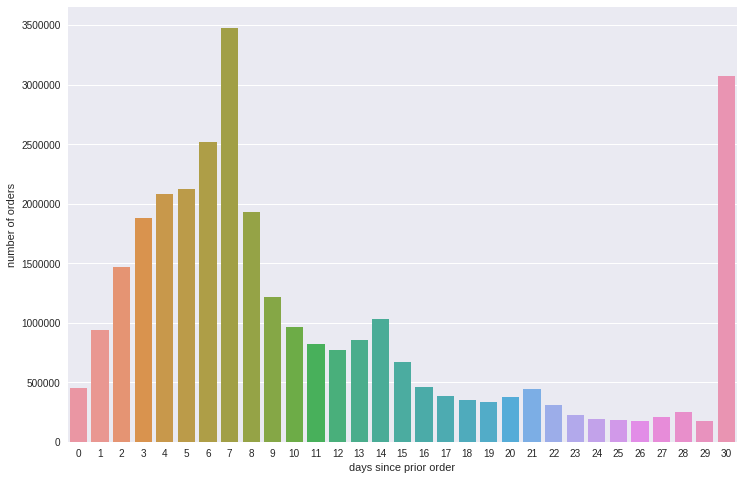

In [10]:
f, ax = plt.subplots(figsize=(12, 8))

sns.barplot(x=summary_days_since_prior_order.index,
            y=summary_days_since_prior_order.values)

ax.set_xlabel('days since prior order')
ax.set_ylabel('number of orders')

plt.show()

## Product ordering over time

In [11]:
product_total_orders = partial_df[['product_id', 'order_id']].groupby(['product_id']).count()

In [12]:
product_total_orders.columns = ['count']

In [19]:
def get_product_order_count_by_hour(df, pids):
    stats = np.array([], dtype=np.int64).reshape(0, 24)

    # getting stats by product
    for pid in pids:
        y = df[df['product_id'] == pid]['order_hour_of_day'].value_counts(sort=False)
        
        # filling with 0s when no order has occurred
        product_stats = y.reindex(range(24), fill_value=0).values
        
        # stacking
        stats = np.vstack((stats, product_stats))

    stats_df = pd.DataFrame(stats.astype(np.int32))
    
    # melting
    stats_df['pid'] = bestselling_product_ids
    stats_df = stats_df.melt(id_vars=['pid'])

    stats_df.columns = ['product_id', 'hour', 'count']
    stats_df['dummy'] = 0
    
    return stats_df

In [14]:
products = pd.read_csv("data/products.csv")

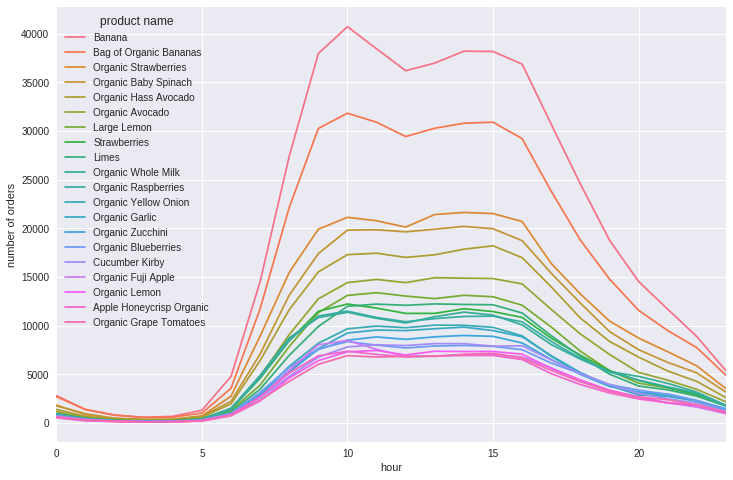

In [27]:
k = 20
bestselling_product_ids = product_total_orders.sort_values(['count'], ascending=False).head(k).index

bestselling_products_hourly_df = get_product_order_count_by_hour(partial_df, bestselling_product_ids)

bestselling_products_hourly_df = bestselling_products_hourly_df.merge(products[['product_id',
                                                                                'product_name']], on='product_id')

f, ax = plt.subplots(figsize=(12, 8))

sns.tsplot(bestselling_products_hourly_df, time='hour', unit='dummy', condition='product_name', value='count')

ax.set_xlabel('hour')
ax.set_ylabel('number of orders')
ax.legend_.set_title('product name')

plt.show()